# Notebook version of QAOA

In [2]:
# This Notebook is an independent implementation of QAOA using Q# and Python.

# Needed libraries

# pip install numpy
# pip install matplotlib
# pip install docplex
# pip install qsharp
# pip install scipy
# pip install qiskit_optimization

# Importing required libraries
# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

# Qsharp
import qsharp

# Quantum Approximate Optimization Algorithm (QAOA)

The Quantum Approximate Optimization Algorithm (QAOA) is an algorithm for solving combinatorial optimization problems; Here we provide the steps we need to take in order to run QAOA.

## Mapping to a Hamiltonian

QUBO's can be mapped to a Hamiltonian which can then be implemented on a Quantum Computer. This mapping is usually done to an Ising Model. An example map is $x_i \rightarrow \frac{1- Z_i}{2}$, which maps a binary variable $x_i$ to Pauli spin $Z_i$. We can use this map to get the Cost Hamiltonian $H_C$, 

\begin{equation}\tag{1}
    H_C =  \sum_{i,j}^{n} \frac{1}{4} Q_{ij} Z_i Z_j - \sum_{j}^{n} \frac{1}{2} \left( c_i + \sum_{i}^{n} Q_{ij} \right) Z_i.
\end{equation}

Once we have the Cost Hamiltonian we can define the Mixer Hamiltonian $H_M$ as

\begin{equation}\tag{2}
    H_M = \sum_{i}^{n} X_i.    
\end{equation}


## Implementing the Hamiltonians

Once we have the Hamiltonians we must define unitaries representing the Hamiltonian's ($H_C$ and $H_M$).

\begin{align}
    \hat U_C(\gamma) &= e^{-i\gamma H_C} \tag{3a}\\
    \hat U_M(\beta) &= e^{-i\beta H_M}, \tag{3b}
\end{align}

Where $\gamma$ and $\beta$ are variational parameters of the circuit. 
We call $\hat U_C(\gamma)$ and $\hat U_M(\beta)$ the cost and mixer layers, respectively.
A single QAOA layer consists of one cost and one mixer layer, which can be further stacked to build a deeper circuit with more layers. Each element in the mixer layer can be implemented with a single rotation gate $R_X$. 

\begin{equation}\tag{4}
    \hat U_M(\beta) = e^{-i\beta H_M} = \prod_{i=1}^n R_{X_i}(2\beta)
\end{equation}

\begin{equation}\tag{5}
    \hat U_C(\gamma) = \prod_{i=1, j<i}^n R_{Z_iZ_j} \left( \frac{1}{4}Q_{ij} \gamma \right)
    \prod_{i=1}^n R_{Z_i} \left(  \frac{1}{2} \left( c_i + \sum_{j=1}^{n} Q_{ij} \right) \gamma \right)
\end{equation}

(4) and (5) are the gate decomposition of the unitaries in (3). 

## Layers

Define the total number of QAOA layers, $p \geq 1$. 
Initialize the $2p$ variational parameters ${\gamma} = (\gamma_1,\gamma_2,\ldots,\gamma_p)$ and ${\beta} = (\beta_1,\beta_2,\ldots,\beta_p)$ such that $\gamma_k \in [0,2\pi)$ and $\beta_k \in [0,\pi)$ for $k = 1, \dots, p$. 

The final state output by the circuit is, therefore, given by
    
\begin{equation}\tag{6}
  \ket{\psi_p({\gamma},{\beta})} = e^{-i\beta_p H_M} e^{-i\gamma_p H_C} \ldots e^{-i\beta_1 H_M} e^{-i\gamma_1H_C} \ket{s}.
\end{equation}

## Measurement and Expectation Value

The expectation value of the Hamiltonian $h_C$ with respect to the ansatz state $\ket{\psi_p({\gamma},{\beta})}$, which corresponds to the cost obtained by the quantum algorithm for the underlying problem, is calculated through repeated measurements of the final state in the computational basis:


\begin{equation}\tag{7}
  F_p({\gamma},{\beta}) =  \bra {\psi_p({\gamma},{\beta})} {H_C} \ket {\psi_p({\gamma},{\beta})}
\end{equation}

## Optimizer

A classical optimization algorithm is employed to iteratively update the parameters ${\gamma}$ and ${\beta}$. The goal of the aforementioned routine is to find the optimal set of parameters $({\gamma}^*,{\beta}^*)$ such that the expectation value $F_p({\gamma},{\beta})$ is maximized:

\begin{equation}\tag{8}
  ({\gamma}^*,{\beta}^*) = \arg\min_{{\gamma},{\beta}} F_p({\gamma},{\beta})
\end{equation}

In [3]:
# Defining helper functions.
def find_most_common_solutions(input_dict, n):
    """
    Sorts the keys of the input dictionary in descending order based on their values and returns the first n keys.

    Arguments:
        input_dict (dict): A dictionary containing the keys and their corresponding values.
        n (int): The number of most common solutions to return.

    Returns:
        list: A list of the n most common keys sorted in descending order based on their values.
    """
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]


# Building the model and its Cost Function
def build_qubo(arr: list):
    """
    Function to build a QUBO (Quadratic Unconstrained Binary Optimization) model from a given array
    for the Number Partitioning Problem (NPP).

    Arguments:
        arr (list): a list of integers representing the array from which the QUBO model is built

    Returns:
        tuple: containing the quadratic coefficients, linear coefficients, and the QUBO model
    """

    # Length of the array - Length of the binary vector x
    n = len(arr)
    # Sum of the array - c
    c = sum(arr)

    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)

    # Cost Function for Number Partitioning Problem (NPP)
    Q =  (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
    model.minimize(Q)   
    problem = from_docplex_mp(model)

    # QUBO formulation
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)

    # Quadratic and Linear Coefficients
    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo

def integer_to_counts(n: int, result: list) -> dict:
    """
    Given a list of integers (output of the circuit), returns a dictionary with the counts of each integer.

    Args:
        n (int): The number of qubits in the circuit. Width of the bitstring.
        a (list): The integer array to be converted.

    Returns:
        dict: A dictionary representing the counts of the integers (bitstrings).

    Example:
        >>> interger_to_counts(2 ,[1, 2, 3, 2, 1, 0])
        {'00': 1, '01': 2, '10': 1, '11': 0}
    """
    counts = {}
    for i in range(2**n):
        counts[np.binary_repr(i,width=n)] = 0
    for integer in result:
        counts[np.binary_repr(integer,width=n)] += 1
    return counts

def arr_to_str(a: np.ndarray) -> str:
    """
    Converts a given array to a string representation.

    Args:
        a (list): The array to be converted.

    Returns:
        str: The string representation of the array.

    Example:
        >>> arr_to_str([1, 2, 3])
        '[1, 2, 3]'
    """
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string[:-1] + ']'

## QAOA in Q# 

Below is the code written in Q# for running the QAOA circuit.

> Note: Run the *Q#* code only once per run as running the *Q#* again during the same run will give an error. 

In [4]:
%%qsharp
// This is the Q# snippet used to create and simulate the QAOA circuit. 
namespace qaoa_note{

    open Microsoft.Quantum.Measurement;

    // Function for getting flat index
    operation flat_index(n: Int, i: Int, j: Int): Int{
        return n*i + j
    }
    // Cost Hamiltonian
    operation cost_unitary(qubits: Qubit[], gamma: Double, quadratics: Double[], linears: Double[]): Unit{
        
        let n_qubits = Length(linears);
        mutable quad_sum : Double = 0.0;

        // RZ Gates
        for qubit in 0..n_qubits-1{
            set quad_sum = 0.0;
            for quad_qubit in 0..n_qubits-1{
                set quad_sum += quadratics[flat_index(n_qubits,qubit,quad_qubit)];
            }
            Rz(0.5 * (linears[qubit] + quad_sum) * gamma, qubits[qubit])
        }
        // RZZ Gates
        for i in 0..n_qubits-1{
            for j in i+1..n_qubits-1{                
                Rzz(0.25 * quadratics[flat_index(n_qubits,i,j)] * gamma, qubits[i], qubits[j])
            }
        }
    }

    // Mixer Hamiltonian
    operation mixer_unitary(qubits: Qubit[], beta: Double) : Unit{
        for qubit in qubits{
            Rx(2.0 * beta,qubit);
        }
    }

    // Function to create the QAOA circuit.
    operation circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[], linears: Double[]) : Int {

        use q = Qubit[NQubits]; 
        mutable integer_result = 0;
        
        // State Preparation |+>
        ApplyToEachA(H,q);

        for layer in 0..Layers-1{
            cost_unitary(q, gammas[layer], quadratics, linears);
            mixer_unitary(q, betas[layer]);
        }
        // Return the bitstring as an integer.
        return MeasureInteger(q);
    }
}


# Optimization


In [5]:
# Global variables for function calls and tracking cost.
func_call = 0
theta = []
cost = []

# Callback function
def callback_func(x):
    theta.append(x)
    return None

# QAOA Function for the Number Partitioning Problem
def qaoa_NPP(arr,layers:int):
    """
    Function implementing the QAOA algorithm for the Number Partitioning Problem.

    Args:
        arr (list): a list of integers.
        layers (int): the number of layers in the QAOA circuit.
    Returns:
        counts (dict): a dictionary containing the counts of each bitstring.

    """
    # Building the QUBO for NPP
    quadratics, linears, qubo = build_qubo(arr)
    num_qubits = len(arr)

    # Preparing the coefficients as flattened numpy arrays
    quadratics = quadratics.toarray().flatten()
    linears = linears.toarray()

    def npp_obj(bit_string, arr):
        """Calculate the objective value for a given bit string for NPP.
        
        Args:
            bit_string (str): Bit string representing the partition.
            arr (list): List of integers representing the numbers to be partitioned.
            
        Returns:
            float: Objective value (absolute difference between sums of partitions).
        """
        sum_0 = 0
        sum_1 = 0
        for i in range(len(bit_string)):
            if bit_string[i] == '0':
                sum_0 += arr[i]
            else:
                sum_1 += arr[i]
        return abs(sum_0 - sum_1)


    # Objective function we want to optimize
    def expectation_value(theta):
        # Global variables update
        global func_call 
        func_call = func_call + 1

        # Splitting the theta array into gammas and betas
        middle = int(len(theta)/2)
        gammas = theta[:middle]
        betas = theta[middle:]

        # Input string for the Q# function.
        input_str = f"{num_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

        # Calling the Q# function with 100 shots.
        int_results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)

        # Converting the results to counts
        counts = integer_to_counts(num_qubits, int_results)
        avg = 0
        sum_count = 0
        for bit_string, count in counts.items():
            obj = npp_obj(bit_string, arr)
            avg += obj * count
            sum_count += count
            
        exp = avg/sum_count
        
        # Calculating the expectation value for the best solution
        # best_sol = max(counts, key=counts.get)
        # exp =  qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))
        
        # Appending to cost array
        cost.append(exp)
        
        # Printing the cost
        print(f'Function call: {func_call} - Cost: {exp}')

        return exp
  

    # Initial guess for gammas and betas
    # init_gamma = np.array([pi / 3] * layers)
    # init_beta = np.array([pi / 4] * layers)
    # initial_guess = np.concatenate((init_gamma, init_beta))
    initial_guess = [1,1,1,1] 
    # Minimization of the objective function. We are using the COBYLA optimizer.
    start_time = time.time()
    res = minimize(expectation_value, initial_guess, method='COBYLA',callback=callback_func)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'\nElapsed time for QAOA: {elapsed_time} seconds')

    # Preparing the final gammas and betas
    middle = int(len(res.x)/2)
    prime_gammas = res.x[:middle]
    prime_betas = res.x[middle:]

    # Printing the optimal parameters
    print(f'Gammas: {prime_gammas}\nBetas: {prime_betas}\nFinal Cost: {res.fun}\n')

    # Preparing the input string with optimal gammas and betas 
    input_str = f"{num_qubits},{layers},{arr_to_str(prime_gammas)},{arr_to_str(prime_betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

    # Calling the Q# function with optimal gammas and betas
    results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)
    counts = integer_to_counts(num_qubits, results)
    
    return counts

# Defining a test array
test_array = [2,1,3,5]
layers = 2

# Running QAOA on for Number Partitioning.
counts = qaoa_NPP(test_array,layers)

Function call: 1 - Cost: 4.72


Function call: 2 - Cost: 7.04


Function call: 3 - Cost: 5.04


Function call: 4 - Cost: 5.06


Function call: 5 - Cost: 6.6


Function call: 6 - Cost: 5.06


Function call: 7 - Cost: 4.76


Function call: 8 - Cost: 7.18


Function call: 9 - Cost: 4.12


Function call: 10 - Cost: 5.02


Function call: 11 - Cost: 3.18


Function call: 12 - Cost: 4.48


Function call: 13 - Cost: 6.34


Function call: 14 - Cost: 5.76


Function call: 15 - Cost: 4.6


Function call: 16 - Cost: 5.2


Function call: 17 - Cost: 5.3


Function call: 18 - Cost: 4.2


Function call: 19 - Cost: 3.02


Function call: 20 - Cost: 2.88


Function call: 21 - Cost: 5.52


Function call: 22 - Cost: 4.96


Function call: 23 - Cost: 3.28


Function call: 24 - Cost: 3.36


Function call: 25 - Cost: 2.96


Function call: 26 - Cost: 2.8


Function call: 27 - Cost: 3.2


Function call: 28 - Cost: 3.58


Function call: 29 - Cost: 2.82


Function call: 30 - Cost: 3.58


Function call: 31 - Cost: 2.9


Function call: 32 - Cost: 2.96


Function call: 33 - Cost: 3.22


Function call: 34 - Cost: 2.56


Function call: 35 - Cost: 3.36


Function call: 36 - Cost: 2.58


Function call: 37 - Cost: 3.44


Function call: 38 - Cost: 3.12


Function call: 39 - Cost: 2.82


Function call: 40 - Cost: 2.9


Function call: 41 - Cost: 3.02


Function call: 42 - Cost: 2.88


Function call: 43 - Cost: 3.48


Function call: 44 - Cost: 3.2


Function call: 45 - Cost: 2.86


Function call: 46 - Cost: 3.4


Function call: 47 - Cost: 2.78

Elapsed time for QAOA: 1.2481448650360107 seconds
Gammas: [1.02201745 0.88612452]
Betas: [0.89240376 1.04965624]
Final Cost: 2.78



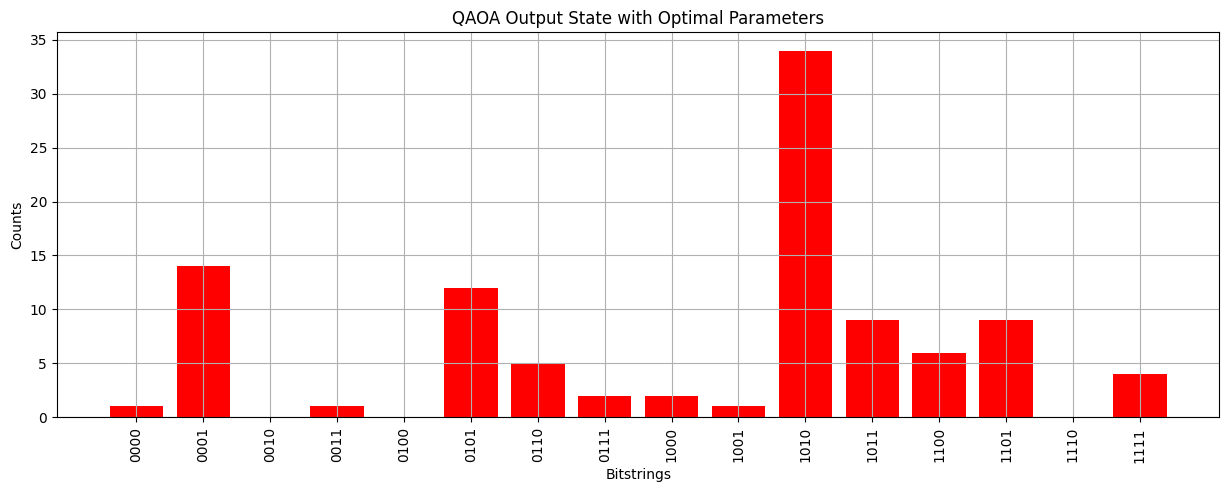

In [6]:
# Plotting the optimal output state.
plt.figure(figsize=(15, 5))
plt.bar(range(len(counts)), list(counts.values()), align='center', color='red')
plt.xticks(range(len(counts)), list(counts.keys()), rotation=90)
plt.title("QAOA Output State with Optimal Parameters")
plt.xlabel("Bitstrings")
plt.ylabel("Counts")
plt.grid()
plt.show()

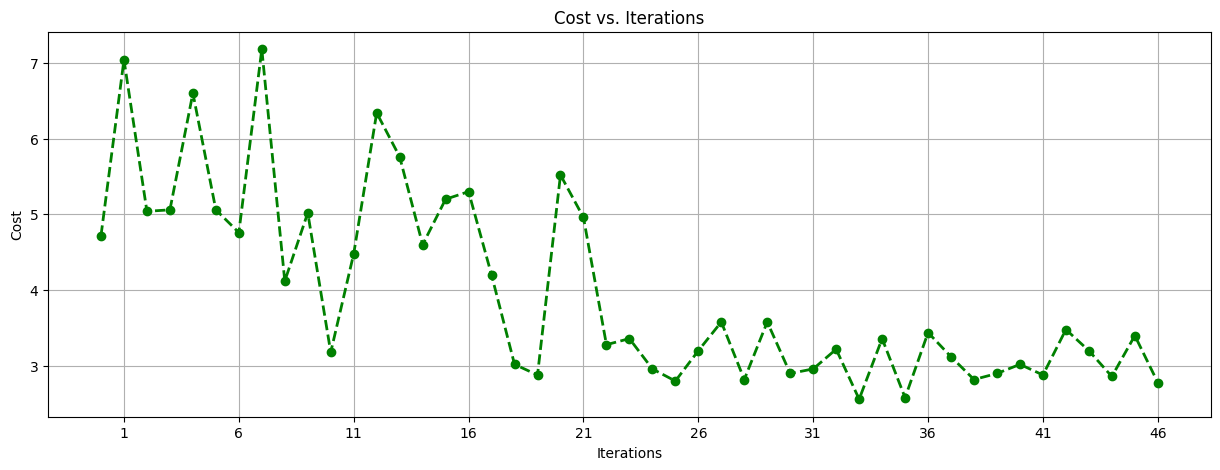

In [7]:
# Plotting Cost vs Iterations.
plt.figure(figsize=(15, 5))
plt.plot(range(len(cost)),cost,color='g',ls='--',marker='o',lw=2)
plt.xticks(range(1,len(cost)+1,5))
plt.title('Cost vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()

In [8]:
# Function to print solutions for NPP.
def print_solution(counts):
    
    # Printing Solutions Sets.
    best_sol = find_most_common_solutions(counts,3)
    print(f'Top 3 solutions for the array {test_array} and {layers} layers: \n{best_sol}')

    # Calculating S and S_A
    S = []
    S_A = []
    for ind,bit in enumerate(best_sol[0]):
        if bit == '1':
            S.append(ind)
        else:
            S_A.append(ind)

    # Calculating Sum(S) and Sum(S/A)
    sum_S = sum(np.array(test_array)[S])
    sum_S_A = sum(np.array(test_array)[S_A])

    # Printing the best optimal partition.
    print(f'\nBest Partition:\nS: {np.array(test_array)[S]}\nSum(S) = {sum_S}\n\nS/A: {np.array(test_array)[S_A]}\nSum(S/A) = {sum_S_A}')
    return None

In [9]:
print_solution(counts)

Top 3 solutions for the array [2, 1, 3, 5] and 2 layers: 
['1010', '0001', '0101']

Best Partition:
S: [2 3]
Sum(S) = 5

S/A: [1 5]
Sum(S/A) = 6
